CPEN 436 Final Project
Connor Studebaker

## 1.

The biomedical problem explored in this project is how to predict a countris income classifcation based on its malnutrition data being explicitely just its severe wasting data. This problem is important because it can help us show and understand how that lower income countries are at higher risk of their children having malnutrition which can lead to other health complications.


## Packages 

- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- [tensorflow](https://www.tensorflow.org/) a popular platform for machine learning.
- pandas to handle data handling from the csv file format
- sklearn to handle means error and r2 score for regression model and test data splitting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

## 2. dataset preprocessing

this dataset come from the United Nations Children's Fund (UNICEF)

theres several featureas in this dataset including "Income Classification, Underweight, Wasting. Severe Wasting, Stunting, Overweight, and U5 Population" 
but for this project I'm only going to use Income Classification and Severe Wasting in order to see if you can predict a countries Income classification based on its Severe Wasting value.

I used pandas to read the data due to its simplicity, and is easily able to be converted a numpy array for the functions

In [2]:
data = pd.read_csv('./country-wise-average.csv')
print ('The shape of data is: ',  data.shape)
data.head() #visualition of the raw data

The shape of data is:  (152, 8)


,Country,Income Classification,Severe Wasting,Wasting,Overweight,Stunting,Underweight,U5 Population ('000s)
0,AFGHANISTAN,0.0,3.033333,10.350000,5.125000,47.775000,30.375000,4918.561500
1,ALBANIA,2.0,4.075000,7.760000,20.800000,24.160000,7.700000,232.859800
2,ALGERIA,2.0,2.733333,5.942857,12.833333,19.571429,7.342857,3565.213143
3,ANGOLA,1.0,2.400000,6.933333,2.550000,42.633333,23.600000,3980.054000
4,ARGENTINA,2.0,0.200000,2.150000,11.125000,10.025000,2.600000,3613.651750


now once we have the data we need to preprocess it.
to do this we are going to use zscore_normalization in order to cut down on the compute cost once we start preocessing the data and to ensure consistent scale in each feature.

To deal with missing data within the dataset I choose to fill all NaN's with the median value for their respective feature. This makes it so that the shape of all the data is able to fit in the functions

other features in dataset are dropped as we're not working with them.

In [3]:
data_mean = data.mean(numeric_only=True)
data_std=data.std(numeric_only=True)
data_mean = data_mean.values
data_std = data_std.values
print ('The shape of data_mean is: ',  data_mean.shape)
print ('The shape of data_std is: ',  data_std.shape)

def zscore_normalize_features(X,X_mean,X_std):
  X_nums = X.select_dtypes(include=['float64', 'int64'])
  data_norm = (X_nums - X_mean) / X_std
  return (data_norm)

data_norm = zscore_normalize_features(data,data_mean,data_std)
#now drop features we dont care about
columns_to_keep = ['Severe Wasting', 'Income Classification']  # replace with the names of the columns you want to keep
data_norm = data_norm[columns_to_keep]
data_norm['Severe Wasting'] = data_norm['Severe Wasting'].fillna(data_norm['Severe Wasting'].median()) #replace nan with median for consistency in cost later on
data_norm['Income Classification'] = data_norm['Income Classification'].fillna(data_norm['Income Classification'].median()) #replace nan with median for consistency in cost later on
print ('The shape of data_norm is: ',  data_norm.shape)
if data_norm.isna().any().any():
    print("Warning: NaN values found in the dataset after filling!")
else:
    print("No NaN values in the dataset!")
print(data_norm)



The shape of data_mean is:  (7,)
The shape of data_std is:  (7,)
The shape of data_norm is:  (152, 2)
No NaN values in the dataset!
     Severe Wasting  Income Classification
0          0.505977              -1.476322
1          1.115517               0.591890
2          0.330429               0.591890
3          0.135377              -0.442216
4         -1.151972               0.591890
..              ...                    ...
147       -0.173295               0.591890
148        0.095147              -0.442216
149        1.832336              -1.476322
150       -0.073609              -0.442216
151       -0.456284              -0.442216

[152 rows x 2 columns]


This project use 2 different models to predict how a countries Severe wasting score can predict its Income classification.

The first model used is a Kmeans-clustering, to test unsupervised learning on this dataset.

## Kmeans-Clustering

First we have all the functions needed for the Kmeans-clustering model to work. Which includes finding the closet centriods, computing the centriods, and initializing the Kmeans-clustering.

Also I choose to implement the Kmeans-clustering twice using different methods to find the centriods. I did this so that it can be basically the equivilent of parameter tuning for a unsupervised learning algorithm.

finding the closet centriods for training each value if X(i) to its closet centriod

In [4]:
def find_closest_centroids(X, centroids):
    """
    Computes the centroid memberships for every example
    
    Args:
        X (ndarray): (m, n) Input values      
        centroids (ndarray): k centroids
    
    Returns:
        idx (array_like): (m,) closest centroids
    
    """

    K = centroids.shape[0]
    idx = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]):
        distance = np.linalg.norm(X.iloc[i].values - centroids, axis=1)
        idx[i] = np.argmin(distance)
    
    return idx

computing centriods, recomputes the mean of the points that assigned to the centriod

In [5]:
def compute_centroids(X, idx, K):
    """
    Returns the new centroids by computing the means of the 
    data points assigned to each centroid.
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        K (int):       number of centroids
    
    Returns:
        centroids (ndarray): (K, n) New centroids computed
    """
    m, n = X.shape
    centroids = np.zeros((K, n))
    for i in range(K):
        points = X[idx==i]
        centroids[i] = np.mean(points, axis=0)
    
    return centroids

using random initialization for initializing the centroids is to select random examples from the training set.
And the first Kmeans algorithm implementation based on the finding the closet centroids function/method

In [6]:
def kMeans_init_centroids(X, K):
    
     # Randomly reorder the indices of examples
    randidx = np.random.choice(X.index,K,replace=False)

    # Take the first K examples as centroids
    centroids = X.loc[randidx].values
    
    return centroids

def run_kMeans(X, initial_centroids, max_iters=10, plot_progress=False):
    """
    Runs the K-Means algorithm on data matrix X, where each row of X
    is a single example
    """
    
    # Initialize values
    m, n = X.shape
    K = initial_centroids.shape[0]
    centroids = initial_centroids
    previous_centroids = centroids    
    idx = np.zeros(m)
    
    # Run K-Means
    for i in range(max_iters):
        
        #Output progress
        print("K-Means iteration %d/%d" % (i, max_iters-1))
        
        # For each example in X, assign it to the closest centroid
        idx = find_closest_centroids(X,centroids)
        
        # Optionally plot progress
        if plot_progress:
            plot_progress_kMeans(X, centroids, previous_centroids, idx, K, i)
            previous_centroids = centroids
            
        # Given the memberships, compute new centroids
        centroids = compute_centroids(X,idx,K)
    plt.show() 
    return centroids, idx

This runs the algorithm and plots the resulting data

K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9


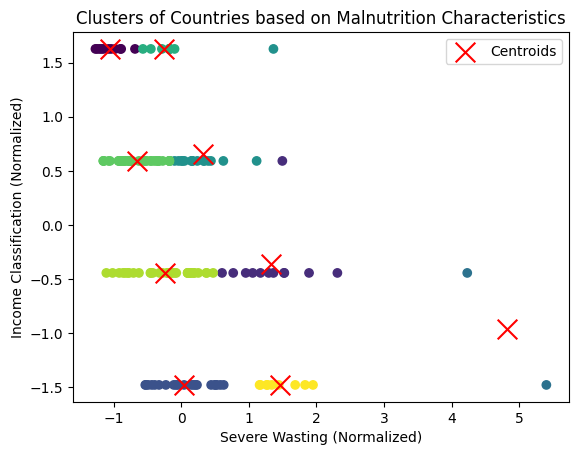

In [7]:
K = 9   #cluster amounts      
max_iters = 10

# Using the function you have implemented above. 
initial_centroids = kMeans_init_centroids(data_norm, K) 

# Run K-Means - this takes a couple of minutes
centroids, idx = run_kMeans(data_norm, initial_centroids, max_iters) 

plt.scatter(data_norm.iloc[:, 0], data_norm.iloc[:, 1], c=idx, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=200, label='Centroids')
plt.legend()
plt.xlabel('Severe Wasting (Normalized)')
plt.ylabel('Income Classification (Normalized)')
plt.title('Clusters of Countries based on Malnutrition Characteristics')
plt.show()

The plot above shows the relationship between severe wasting (normalized) and income classification (normalized) grouped into cluster, with centroids of the clusters also being included.

To  regularize the data I adjusted the K value for the amount of clusters, I settled on 9 clusters, this value accurately represents the amount of different data clusters as you can see on the plot. Originally I had 5 clusters but it resulted in the centroids not fitting onto the clusters, while you can clearly see the centroids fitting onto the clusters accurately.

Based on this plot of centroids and clusters we can clearly see the data contains several groups of countries with similar level of severe wasting and income classification. Based on these clusters being grouped together you can see how as some Countries have a higher Income Classification they have less severe wasting. This shows us how we can potentially predict what a countries Income classification is based on its severe wasting score.



Now for the second implementation of the Kmeans-clustering model, we are going to try to find more accurate centriods by running the Kmeans algorithm multiple times with different initializations in order to get more accurate values. Then choose the one with the lowest cost. 

functions for computing costs and finding better centriods, since data_norm is a pandas array you have to convert it to a numpy array in order for the functions to work.

I've also implemented a function that auto reruns the find closet centroid function if a NaN somehow occurs, this allows for higher K values to be tested but signifitcantly increased the processing time

In [8]:
def compute_cost(X, idx, centroids):
    """
    This function computes the cost given centroids and idx
    
    Args:
        X (ndarray):   (m, n) Data points
        idx (ndarray): (m,) Array containing index of closest centroid for each 
                       example in X. Concretely, idx[i] contains the index of 
                       the centroid closest to example i
        centroids (ndarray): identified centroids
    
    Returns:
        cost: cost defined above
    """
          
    m = X.shape[0]
    cost = 0
    if np.isnan(X).any() or np.isnan(centroids).any():
        raise ValueError("X or centroids contain NaN values.")
    if not np.all((idx >= 0) & (idx < centroids.shape[0])):
        raise ValueError("Invalid indices in idx array.")

    # Compute the cost
    for i in range(m):
        diff = X[i] - centroids[idx[i]]
        norm = np.linalg.norm(diff)**2
        if np.isnan(norm):
            print(f"Invalid calculation at index {i}:")
            print("X[i]:", X[i])
            print("Centroid:", centroids[idx[i]])
        cost += norm

    return cost / m

def find_best_centroids(X, K, max_iters_centroids,max_iters_kmean):
    """
    This function computes the cost given centroids and idx
    
    Args:
        X (ndarray):   (m, n) Data points
        K (int):     number of centroids/clusters
        max_iters_centroids (int): number of different initilizations we want to try
        max_iters_kmean (int):  number of iterations for run_kMeans()
    
    Returns:
        best_centroids: best centroids after trying different random initilizations of the K centroids
        lowes_cost: lowest cost for different random initilizations of the K centroids
        
    """
    print("Centroids %d/%d:" % (0, max_iters_centroids-1))
    initial_centroids = kMeans_init_centroids(X, K)
    best_centroids, best_idx = run_kMeans(X, initial_centroids, max_iters_kmean)
    lowes_cost = compute_cost(X.values, best_idx, best_centroids)

    for i in range(max_iters_centroids-1):
        print("Centroids %d/%d:" % (i+1, max_iters_centroids-1))
        initial_centroids = kMeans_init_centroids(X, K)
        centroids, idx = run_kMeans(X, initial_centroids, max_iters_kmean)
        cost = compute_cost(X.values, idx, centroids)
        
        if cost < lowes_cost:
            lowes_cost = cost
            best_centroids = centroids  
    return best_centroids, lowes_cost

# Automatic rerun until success
def auto_run_kMeans(X, K, max_iters_centroids, max_iters_kmean, max_retries=10):
    retries = 0
    centroids, cost = None, None

    while retries < max_retries:
        try:
            print(f"Attempt {retries + 1} for k={K}...")
            centroids, cost = find_best_centroids(X, K, max_iters_centroids, max_iters_kmean)

            # Check if centroids contain NaN
            if centroids is not None and not np.isnan(centroids).any():
                print(f"Successful run for k={K} with cost {cost}")
                return centroids, cost
            else:
                print(f"Centroids contain NaN values on attempt {retries + 1}. Retrying...")
        except ValueError as e:
            print(f"Error: {e} on attempt {retries + 1}. Retrying...")

        retries += 1

    print(f"Failed to find valid centroids after {max_retries} retries for k={K}.")
    return None, None

this runs the second implementation using better centroids, this should get us better results.

## Warning
for some reason a high K value can in an error. If an error does occur just rerun the section a few times then it will pass successfully, if that doesn't work try reducing the K value

Attempt 1 for k=9...
Centroids 0/9:
K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
Error: X or centroids contain NaN values. on attempt 1. Retrying...
Attempt 2 for k=9...
Centroids 0/9:
K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
Centroids 1/9:
K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
Error: X or centroids contain NaN values. on attempt 2. Retrying...
Attempt 3 for k=9...
Centroids 0/9:
K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iterati

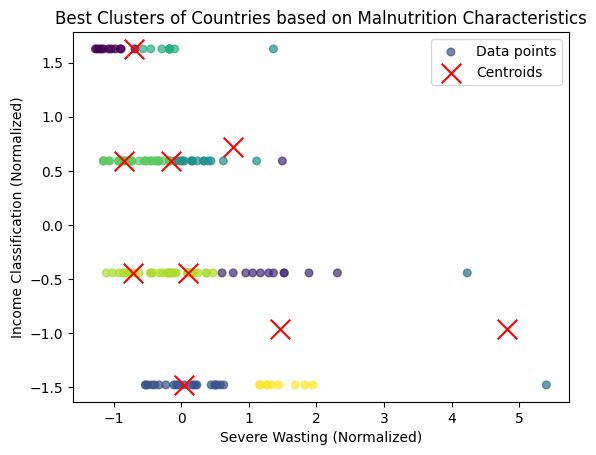

In [9]:
max_iters_centroids = 10
max_iters_kmean = 10
K=9
best_centroids, lowes_cost = auto_run_kMeans(data_norm, K, max_iters_centroids, max_iters_kmean)

plt.scatter(data_norm.iloc[:, 0], data_norm.iloc[:, 1], c=idx, cmap='viridis', s=30, alpha=0.7, label='Data points')
plt.scatter(best_centroids[:, 0], best_centroids[:, 1], marker='x', c='red', s=200, label='Centroids')
plt.legend()
plt.xlabel('Severe Wasting (Normalized)')
plt.ylabel('Income Classification (Normalized)')
plt.title('Best Clusters of Countries based on Malnutrition Characteristics')
plt.show()

Looking at this plot and comparing it to plot above you can clearly see how the centroids are more accurately placed into the clustering of the groups of data. And we can conclude that this second implementation is more accurate than the first. Desite having less clusters the centroids are still more accurate, than the other implementation.

This also helps us conclude that this model can somewhat accurately predict a countries Income Classification based on a Severe Wasting score.

#### Elbow Method for cost
Now to choose the right amount of clusters by the "elbow method," to get the right value of K, we can try different values of K and find the lowest cost for each K. then plot all these costs. 

Attempt 1 for k=2...
Centroids 0/9:
K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
Centroids 1/9:
K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
Centroids 2/9:
K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
Centroids 3/9:
K-Means iteration 0/9
K-Means iteration 1/9
K-Means iteration 2/9
K-Means iteration 3/9
K-Means iteration 4/9
K-Means iteration 5/9
K-Means iteration 6/9
K-Means iteration 7/9
K-Means iteration 8/9
K-Means iteration 9/9
Centroids 4/9:
K-Means iteration 0/9
K-

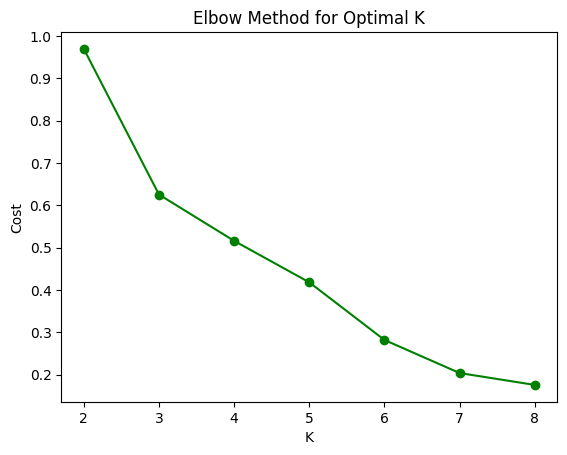

In [10]:
cost_list = []
for k in range(2, 9):
    centroids_cost, cost = auto_run_kMeans(data_norm, k, max_iters_centroids, max_iters_kmean, 10)
    print(f"Cost for k={k}: {cost}")
    cost_list.append(cost)


# Plot the costs
plt.plot(range(2, 9), cost_list, 'og-')
plt.xlabel("K")
plt.ylabel("Cost")
plt.title("Elbow Method for Optimal K")
plt.show()

cost is significantly lower because data has been normalized above.

Looking at the plot we can see how as we tune the parameters (centroids) of the Kmeans clustering algorithm the cost decreases making the algorithm more efficient, so we would be able to predict what a countries Income Classification is based on its Severe  Wasting score.


### Accuracy

In [11]:
cluster_to_label = {}

for cluster in np.unique(idx):
    cluster_points = data_norm[idx == cluster] 
    true_labels = cluster_points['Income Classification']
    if not true_labels.empty:
        cluster_to_label[cluster] = true_labels.mode()[0] 

# assign predicted labels to the dataset based on cluster
data_norm['Predicted Income Classification'] = [cluster_to_label[cluster] for cluster in idx]

print(cluster_to_label)

# to calc the accuracy
correct_predictions = (data_norm['Income Classification'] == data_norm['Predicted Income Classification']).sum()
accuracy = correct_predictions / len(data_norm) * 100
print(f"Accuracy: {accuracy:.2f}%")



{0: 1.6259956067155328, 1: -0.4422163783954377, 2: -1.4763223709509228, 3: -1.4763223709509228, 4: 0.5918896141600475, 5: 1.6259956067155328, 6: 0.5918896141600475, 7: -0.4422163783954377, 8: -1.4763223709509228}
Accuracy: 98.03%


After calculating the accuracy we can see that this unsupervised model is over 90% accurate for predicting the Income Classification from Severe Wasting score. We get this value from the centroids of the the severe wasting scores.

## Linear Regression with One Variable model
Now for another model using linear regression to predict income classifation based on severe wasting data. I'm going to implement this using Sequential model in tensorflow to classify Income Classification and Severe Wasting.

Next data is split upto training data and testing data, 80% of the data is made into the training data and 20% is made into the test data which will be tested on the training data to see how accurately the model can predict whether Severe Wasting can predict Income Classification.

In [12]:
X_severe = data_norm['Severe Wasting']
y_income = data_norm['Income Classification']
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_severe, y_income, test_size=0.2, random_state=42)


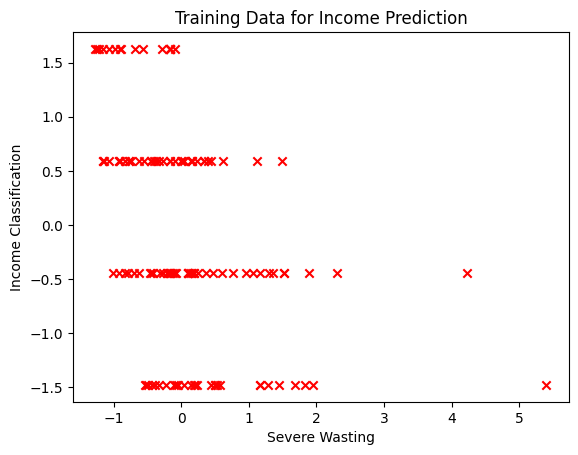

In [13]:
# Plot the data points
plt.scatter(X_train, y_train, marker='x', c='r')
# Set the title
plt.title("Training Data for Income Prediction")
# Set the y-axis label
plt.ylabel('Income Classification')
# Set the x-axis label
plt.xlabel('Severe Wasting')
plt.show()

This plot show the distribution of the training data, so the test data should fit into some of the groups to prove its accuracy.

Keras Sequential model and dense layer with ReLU activation with 4 layer network.
Adding an additional layer increased the models accuracy by over 5%, I discuss this more below when explaining how to increase accuracy.

In [14]:
model = Sequential(
    [               
        tf.keras.Input(shape=(1,)),  #just 1 feature
        tf.keras.layers.Dense(64, activation='relu', name='layer1'), 
        tf.keras.layers.Dense(32, activation='relu', name='layer2'),
        tf.keras.layers.Dense(16, activation='relu', name='layer3'), 
        tf.keras.layers.Dense(1, activation='linear', name='layer4')   
    ], name = "my_model" 
)                            


shows the summary of the parameters and the weights

In [15]:
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer3 (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer4 (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
[layer1, layer2, layer3, layer4] = model.layers
#### Examine Weights shapes
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
W4,b4 = layer4.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")
print(f"W4 shape = {W4.shape}, b4 shape = {b4.shape}")

W1 shape = (1, 64), b1 shape = (64,)
W2 shape = (64, 32), b2 shape = (32,)
W3 shape = (32, 16), b3 shape = (16,)
W4 shape = (16, 1), b4 shape = (1,)


- defines a loss function
- defines an optimizer

In [17]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mean_squared_error', 
              metrics=['mae'])  # Mean Absolute Error as evaluation metric


applies the entire data set during training 50 times

shows the loss of cost

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0000 - mae: 0.8722
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9486 - mae: 0.8426 
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9004 - mae: 0.8202 
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9358 - mae: 0.8310  
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9161 - mae: 0.82949
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8206 - mae: 0.7695  
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7502 - mae: 0.7201
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8243 - mae: 0.7625
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8172 - mae: 0.7578  
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8141 - mae: 0.7513  
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7704 - mae: 0.7270  
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7411 - mae: 0.7215 
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

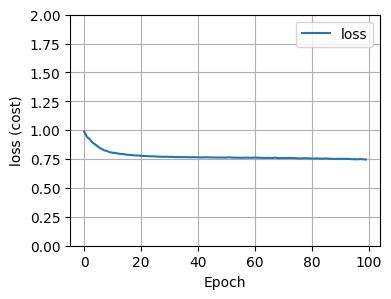

In [18]:
history = model.fit(          
    X_train,y_train,
    epochs=100
)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'           # to support higher OS versions 
fig,ax = plt.subplots(1,1, figsize = (4,3))
ax.plot(history.history['loss'], label='loss')
ax.set_ylim([0, 2])
ax.set_xlabel('Epoch')
ax.set_ylabel('loss (cost)')
ax.legend()
ax.grid(True)
plt.show()

In [19]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.7015 - mae: 0.6769 - val_loss: 0.8578 - val_mae: 0.8119
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6787 - mae: 0.6706 - val_loss: 0.8601 - val_mae: 0.8126
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7223 - mae: 0.7137 - val_loss: 0.8617 - val_mae: 0.8128
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6942 - mae: 0.6871 - val_loss: 0.8649 - val_mae: 0.8133
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6869 - mae: 0.6845 - val_loss: 0.8652 - val_mae: 0.8125
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7401 - mae: 0.7084 - val_loss: 0.8654 - val_mae: 0.8122
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6872 - mae: 0.6730 - val_loss: 0.8661 - val_mae: 0.8130
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.6802 - mae: 0.6647 - val_loss: 0.8660 - val_mae: 0.8125
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7557 - mae: 0.7236 - 

Now to predict the accuracy of the model

In [20]:
y_pred = model.predict(X_test)

# Evaluate using Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")
y_pred = y_pred.reshape(-1) if y_pred.ndim > 1 else y_pred
y_test = y_test
tolerance = 0.32
within_tolerance = np.abs(y_pred - y_test) <= tolerance
accuracy_within_tolerance = np.mean(within_tolerance) * 100
print(f'Accuracy within +/-{tolerance}: {accuracy_within_tolerance:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Mean Squared Error: 0.6999
R-squared: 0.0264
Accuracy within +/-0.32: 38.71%


#### Evaluation

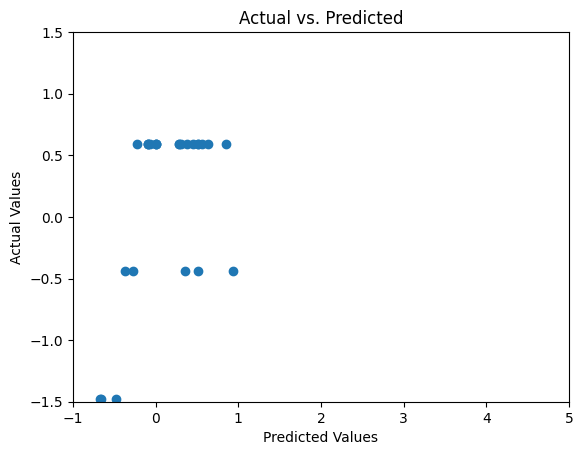

In [21]:
plt.scatter(y_pred, y_test)
plt.xlim(-1,5)
plt.ylim(-1.5,1.5)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Actual vs. Predicted")
plt.show()

This obviously isn't accuracy rating but it was even lower before I changed the parameters of the model. The first model attempt got an accuracy rating of 16.13%, after adding regularization, increasing the model complexity, and increasing the tolerance we get and accuracy of around 38.71%.

I'm choosing not to change the model architecture anymore, and keep the regularization the same in order to prevent overfitting. This accuracy rating of 38.71% does actually tell us a lot though, its able to help us come to the conclusion that the Income Classification does not actually give us a strong indicator of severe wasting within a population.

Looking at the plot of Actual V Predicted we can clearly see that group into 3 large groups. This suggests that this model isn't very accurate or that the training data produces underfitting predictions. But this model suggests that you can't accurately predict a countries Income Classification based on its Severe Wasting Score. You can see a trend in the predictions upward to the right, when in the training data the is downwars from the left.

## Analysis


- kmeans
looking at the plots and costs from the Kmeans-clustering implementation, noticting how the centroids are close to the groups/clusters we can accurately group values. Using the centroids of the clusters we can accurately predict the Income Classification of a country based on its severe wasting score. The prediction only improves when we find better centroids. This algorithm works because its able to accurately find the cluster and centroids of each group in the data. This unsupervised learning model is able to accurately predict over 90% what the Income Classification of a country is based on the Severe Wasting score, this shows that this model is able to work well with this biomedical problem.

- linear regression with one variable
comparing the predicted values with the training values you can clearly see the predicted values don't follow the trend set forth in the training data. And once you take the prediction accuracy into account it's clear that this model is not good for predicting the Income Classification of a country based on its Severe Wasting score. This prediction accuracy of under 50% shows why this model shouldn't be used, and for why it performed so bad it's mostly like to how the training data was normalized which could have messed up the training.

#### Conclusion
In conclusion the use of the Kmeans-clustering should be used over the linear regression with one variable to more accurately predict the Income Classification of a country based on a Severe Wasting score.


